✅ Cargando CSVs:
  - ./Atitlan_cyano_stats.csv
  - ./Amatitlan_cyano_stats.csv
Atitlán: (29, 3)  | Amatitlán: (19, 3)
Atitlan: 2025-02-07 → 2025-08-01 (≈ 175 días)
⚠️ Atención: periodo < 6 meses. Considera ampliar la ventana temporal.
Amatitlan: 2025-02-07 → 2025-08-01 (≈ 175 días)
⚠️ Atención: periodo < 6 meses. Considera ampliar la ventana temporal.


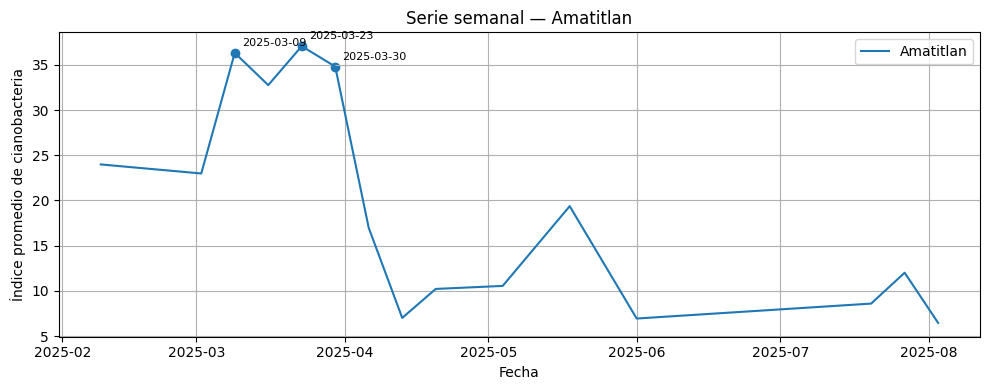

📈 Guardado: ./salidas_avance/figs/amatitlan_timeseries.png


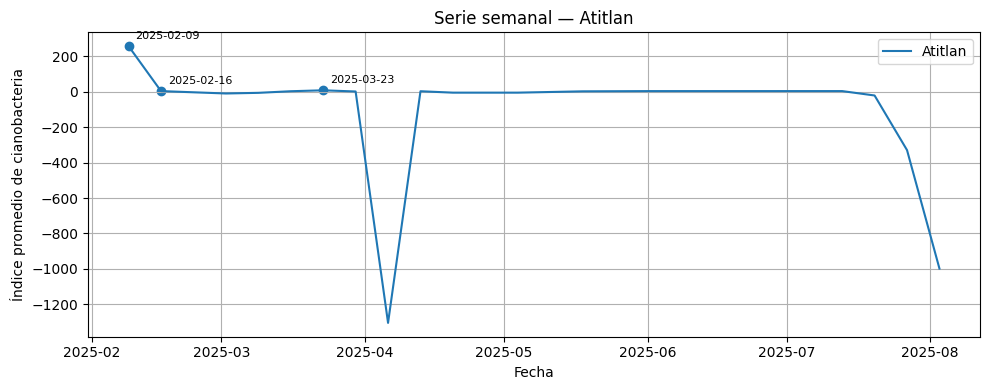

📈 Guardado: ./salidas_avance/figs/atitlan_timeseries.png


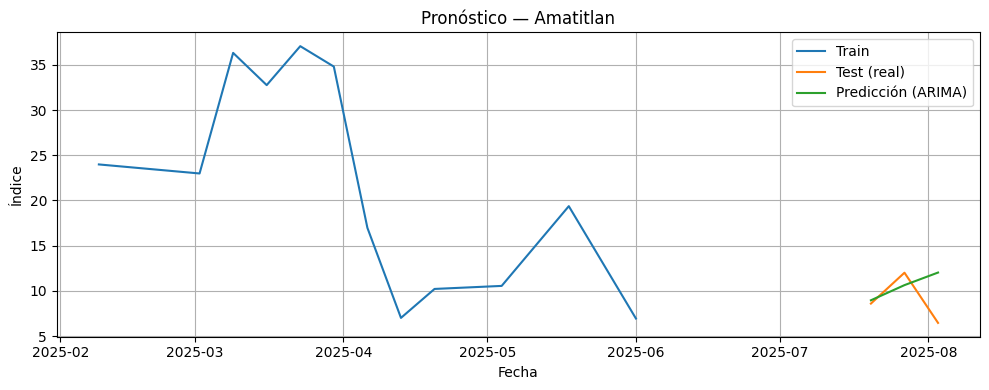

🤖 Guardado: ./salidas_avance/figs/amatitlan_forecast_test.png


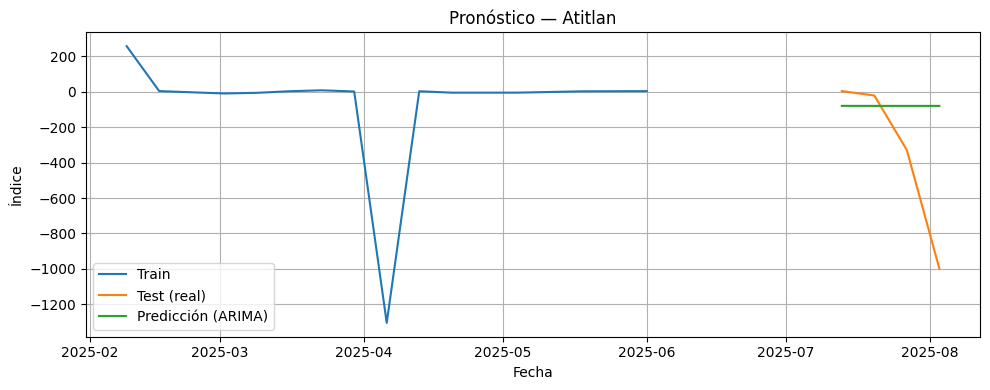

🤖 Guardado: ./salidas_avance/figs/atitlan_forecast_test.png

Métricas:


,lake,n_obs,model,MAE,RMSE,MAPE_%
0,Amatitlan,15,ARIMA,2.437468,3.319737,34.020540
1,Atitlan,17,ARIMA,327.777567,478.906749,626.153383



📦 Archivos exportados:
 - ./salidas_avance/avances_series_temporales_metrics.csv
 - ./salidas_avance/avances_series_temporales_predictions.csv
 - ./salidas_avance/avances_series_temporales_peaks.csv
 - ./salidas_avance/avances_resumen_tabla.csv


,lake,model,n_obs,MAE,RMSE,MAPE_%,Top3_Picos
0,Amatitlan,ARIMA,15,2.437468,3.319737,34.020540,2025-03-23 (≈37.079); 2025-03-09 (≈36.336); 20...
1,Atitlan,ARIMA,17,327.777567,478.906749,626.153383,2025-02-09 (≈257.804); 2025-03-23 (≈8.460); 20...


 - ./salidas_avance/avance_series_temporales_resumen.md

✅ Avance completo. Inserta las PNG de ./salidas_avance/figs en tu slide y copia el Markdown/tabla.


In [2]:
# ================================================================
# Avances – Series Temporales (Atitlán & Amatitlán)

# ================================================================


PATH_ATITLAN  = r"./Atitlan_cyano_stats.csv"
PATH_AMATITLAN= r"./Amatitlan_cyano_stats.csv"
PATH_MERGED   = r"./Lagos_cyano_stats_merged.csv"
OUT_DIR       = r"./salidas_avance"
OUT_FIGS      = OUT_DIR + "/figs"

# ---------------------------------------------------------------
import os, warnings, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from datetime import datetime

warnings.filterwarnings("ignore")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(OUT_FIGS, exist_ok=True)
plt.rcParams["figure.figsize"] = (10, 4)


try:
    from statsmodels.tsa.arima.model import ARIMA
except Exception:
    !{sys.executable} -m pip install -q statsmodels
    try:
        from statsmodels.tsa.arima.model import ARIMA
    except Exception:
        ARIMA = None
        print("⚠️ No fue posible importar statsmodels. Se usará solo el modelo Naive.")

# ---------- Utilidades ----------
def _normalize_two_cols(df, lake_name="", date_guess=("date","fecha","timestamp","time","acquisition_date")):
    cols = {c.lower(): c for c in df.columns}
    date_col = next((cols[k] for k in date_guess if k in cols), None)
    if date_col is None:
        raise ValueError("No se encontró columna de fecha (date/fecha/timestamp/time).")
    prefer = [f"{lake_name}_mean","cyano_mean","mean","indice","index","value"]
    idx_col = next((c for c in prefer if c in df.columns), None)
    if idx_col is None:
        nums = [c for c in df.columns if c != date_col and pd.api.types.is_numeric_dtype(df[c])]
        if not nums:
            raise ValueError("No se encontró columna numérica para el índice.")
        idx_col = nums[0]
    out = df[[date_col, idx_col]].copy()
    out.columns = ["date","value"]
    out["date"] = pd.to_datetime(out["date"])
    out["lake"] = lake_name
    return out.sort_values("date").reset_index(drop=True)

def _from_merged(dfm):
    cols = {c.lower(): c for c in dfm.columns}
    c_date = next((cols[k] for k in ("date","fecha","timestamp","time") if k in cols), None)
    c_lake = next((cols[k] for k in ("lake","lago") if k in cols), None)
    c_val  = next((cols[k] for k in ("value","valor","indice","index","mean","cyano_mean") if k in cols), None)

    # Formato largo
    if c_date and c_lake and c_val:
        t = dfm[[c_date, c_lake, c_val]].copy()
        t.columns = ["date","lake","value"]
        t["date"] = pd.to_datetime(t["date"])
        t["lake"] = t["lake"].astype(str).str.strip().str.title()
        t = t[t["lake"].isin(["Atitlan","Amatitlan","Atitlán","Amatitlán"])].copy()
        t["lake"] = t["lake"].replace({"Atitlán":"Atitlan","Amatitlán":"Amatitlan"})
        dfa = t[t["lake"]=="Atitlan"][["date","value"]].copy(); dfa["lake"]="Atitlan"
        dfb = t[t["lake"]=="Amatitlan"][["date","value"]].copy(); dfb["lake"]="Amatitlan"
        return dfa.reset_index(drop=True), dfb.reset_index(drop=True)

    # Formato ancho
    if c_date:
        wide_cols = [c for c in dfm.columns if "atitlan" in c.lower() or "amatitlan" in c.lower()]
        if len(wide_cols) >= 2:
            dfw = dfm.copy()
            dfw[c_date] = pd.to_datetime(dfw[c_date])
            melted = dfw.melt(id_vars=[c_date], var_name="lake", value_name="value")
            melted["lake"] = melted["lake"].str.extract(r"(Atitlan|Amatitlan)", expand=False).fillna(melted["lake"])
            melted.columns = ["date","lake","value"]
            melted = melted.dropna(subset=["value"])
            dfa = melted[melted["lake"].str.contains("Atitlan", case=False)][["date","value"]].copy(); dfa["lake"]="Atitlan"
            dfb = melted[melted["lake"].str.contains("Amatitlan", case=False)][["date","value"]].copy(); dfb["lake"]="Amatitlan"
            return dfa.reset_index(drop=True), dfb.reset_index(drop=True)

    raise ValueError("No reconozco el formato del archivo 'merged'. Revisa nombres de columnas.")

def load_data():

    local = globals()
    if "df_atitlan" in local and "df_amatitlan" in local:
        print("✅ Usando df_atitlan / df_amatitlan en memoria.")
        return local["df_atitlan"].copy(), local["df_amatitlan"].copy()

    # 2) CSV individuales
    if os.path.exists(PATH_ATITLAN) and os.path.exists(PATH_AMATITLAN):
        print(f"✅ Cargando CSVs:\n  - {PATH_ATITLAN}\n  - {PATH_AMATITLAN}")
        dfa = _normalize_two_cols(pd.read_csv(PATH_ATITLAN), lake_name="Atitlan")
        dfb = _normalize_two_cols(pd.read_csv(PATH_AMATITLAN), lake_name="Amatitlan")
        return dfa, dfb

    # 3) CSV unificado (merged)
    if os.path.exists(PATH_MERGED):
        print(f"✅ Cargando CSV unificado: {PATH_MERGED}")
        dfa, dfb = _from_merged(pd.read_csv(PATH_MERGED))
        return dfa, dfb

    # 4) Convenciones de nombre
    for a,b in [("Atitlan_cyano_stats.csv","Amatitlan_cyano_stats.csv"),
                ("./Atitlan_cyano_stats.csv","./Amatitlan_cyano_stats.csv")]:
        if os.path.exists(a) and os.path.exists(b):
            print(f"✅ Cargando CSVs por nombre convencional:\n  - {a}\n  - {b}")
            dfa = _normalize_two_cols(pd.read_csv(a), lake_name="Atitlan")
            dfb = _normalize_two_cols(pd.read_csv(b), lake_name="Amatitlan")
            return dfa, dfb

    raise FileNotFoundError("No encuentro datos. Descarga de Drive y ajusta PATH_ATITLAN / PATH_AMATITLAN o PATH_MERGED arriba.")

def span_days(df):
    return (df["date"].max() - df["date"].min()).days

def resample_weekly(df):
    dfr = df.set_index("date").resample("W").mean(numeric_only=True)
    dfr["lake"] = df["lake"].iloc[0]
    return dfr.reset_index().dropna(subset=["value"])

def detect_peaks(g, k=3):
    return g.sort_values("value", ascending=False).head(k)[["date","value"]]

def mae(y_true, y_pred):  return float(np.mean(np.abs(np.array(y_true)-np.array(y_pred))))
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2)))
def mape(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred); eps=1e-9
    return float(np.mean(np.abs((y_true - y_pred)/ (np.abs(y_true)+eps))) * 100)

def fit_predict_arima(series):
    if ARIMA is None:
        return None
    for order in [(1,1,1),(1,0,1)]:
        try:
            model = ARIMA(series, order=order).fit()
            return model
        except Exception:
            continue
    return None

# ---------- 1) Carga de datos ----------
df_atitlan_raw, df_amatitlan_raw = load_data()
print("Atitlán:", df_atitlan_raw.shape, " | Amatitlán:", df_amatitlan_raw.shape)

# ---------- 2) Validación de ventana (≥ 6 meses) ----------
for lake, g in [("Atitlan", df_atitlan_raw), ("Amatitlan", df_amatitlan_raw)]:
    days = span_days(g)
    print(f"{lake}: {g['date'].min().date()} → {g['date'].max().date()} (≈ {days} días)")
    if days < 180:
        print("⚠️ Atención: periodo < 6 meses. Considera ampliar la ventana temporal.")

# ---------- 3) Resample semanal ----------
ts_atitlan  = resample_weekly(df_atitlan_raw)
ts_amatitlan= resample_weekly(df_amatitlan_raw)
ts_weekly   = pd.concat([ts_atitlan, ts_amatitlan], ignore_index=True)

# ---------- 4) Gráficas de serie + picos ----------
for lake, g in ts_weekly.groupby("lake"):
    g = g.sort_values("date")
    peaks = detect_peaks(g, k=3)
    plt.figure()
    plt.plot(g["date"], g["value"], label=lake)
    plt.scatter(peaks["date"], peaks["value"])
    for _, r in peaks.iterrows():
        plt.annotate(str(pd.to_datetime(r["date"]).date()), (r["date"], r["value"]),
                     xytext=(5,5), textcoords="offset points", fontsize=8)
    plt.title(f"Serie semanal — {lake}")
    plt.xlabel("Fecha"); plt.ylabel("Índice promedio de cianobacteria")
    plt.grid(True); plt.legend(); plt.tight_layout()
    out = os.path.join(OUT_FIGS, f"{lake.lower()}_timeseries.png")
    plt.savefig(out, dpi=200); plt.show()
    print("📈 Guardado:", out)

# ---------- 5) Modelado (ARIMA -> Naive) ----------
metrics = []
predictions_store = []

for lake, g in ts_weekly.groupby("lake"):
    g = g.sort_values("date").reset_index(drop=True)
    y = g["value"].values
    n = len(y)
    split = max(1, int(n*0.8)) if n >= 12 else max(1, int(n*0.8))

    y_train, y_test = y[:split], y[split:]
    d_train, d_test = g["date"][:split], g["date"][split:]

    model = fit_predict_arima(y_train)
    if model is not None:
        try:
            y_pred = np.asarray(model.forecast(steps=len(y_test)))
            used_model = "ARIMA"
        except Exception:
            y_pred = np.repeat(y_train[-1], len(y_test))
            used_model = "Naive (fallback)"
    else:
        y_pred = np.repeat(y_train[-1], len(y_test))
        used_model = "Naive"

    lake_mae  = mae(y_test, y_pred) if len(y_test)>0 else np.nan
    lake_rmse = rmse(y_test, y_pred) if len(y_test)>0 else np.nan
    lake_mape = mape(y_test, y_pred) if len(y_test)>0 else np.nan

    metrics.append({"lake": lake, "n_obs": n, "model": used_model,
                    "MAE": lake_mae, "RMSE": lake_rmse, "MAPE_%": lake_mape})

    # plot test
    if len(y_test) > 0:
        plt.figure()
        plt.plot(d_train, y_train, label="Train")
        plt.plot(d_test,  y_test,  label="Test (real)")
        plt.plot(d_test,  y_pred,  label=f"Predicción ({used_model})")
        plt.title(f"Pronóstico — {lake}")
        plt.xlabel("Fecha"); plt.ylabel("Índice"); plt.grid(True); plt.legend(); plt.tight_layout()
        out = os.path.join(OUT_FIGS, f"{lake.lower()}_forecast_test.png")
        plt.savefig(out, dpi=200); plt.show()
        print("🤖 Guardado:", out)

    # guardar predicciones de test
    df_pred_test = pd.DataFrame({"date": d_test.values, "lake": lake,
                                 "y_true": y_test, "y_pred": y_pred})
    predictions_store.append(df_pred_test)

    # pronóstico 4 semanas adelante
    if ARIMA is not None and used_model.startswith("ARIMA"):
        try:
            model_full = fit_predict_arima(y)
            fc_future = np.asarray(model_full.forecast(steps=4))
        except Exception:
            fc_future = np.repeat(y[-1], 4)
    else:
        fc_future = np.repeat(y[-1], 4)
    future_dates = pd.date_range(start=g["date"].iloc[-1] + pd.Timedelta(days=7), periods=4, freq="W")
    predictions_store.append(pd.DataFrame({"date": future_dates, "lake": lake, "forecast": fc_future}))

metrics_df = pd.DataFrame(metrics)
print("\nMétricas:")
display(metrics_df)

# ---------- 6) Exportar CSVs ----------
metrics_path = os.path.join(OUT_DIR, "avances_series_temporales_metrics.csv")
preds_path   = os.path.join(OUT_DIR, "avances_series_temporales_predictions.csv")
peaks_path   = os.path.join(OUT_DIR, "avances_series_temporales_peaks.csv")

# reconstruir peaks_report para exportar
peaks_list = []
for lake, g in ts_weekly.groupby("lake"):
    p = detect_peaks(g, 3).copy()
    p["lake"] = lake
    peaks_list.append(p)
peaks_report = pd.concat(peaks_list, ignore_index=True)

metrics_df.to_csv(metrics_path, index=False)
pd.concat(predictions_store, ignore_index=True).to_csv(preds_path, index=False)
peaks_report.to_csv(peaks_path, index=False)

print("\n📦 Archivos exportados:")
print(" -", metrics_path)
print(" -", preds_path)
print(" -", peaks_path)

# ---------- 7) Resumen para slide ----------
# Top-3 picos en una línea
peaks_txt = (
    peaks_report.sort_values(["lake","value"], ascending=[True, False])
    .groupby("lake")
    .apply(lambda d: "; ".join([f"{pd.to_datetime(r.date).date()} (≈{r.value:.3f})"
                                for r in d.head(3).itertuples()]))
    .rename("Top3_Picos").reset_index()
)
summary = metrics_df.merge(peaks_txt, on="lake", how="left")[["lake","model","n_obs","MAE","RMSE","MAPE_%","Top3_Picos"]]
summary_path = os.path.join(OUT_DIR, "avances_resumen_tabla.csv")
summary.to_csv(summary_path, index=False)
print(" -", summary_path)
display(summary)

# ---------- 8) Mini-informe Markdown ----------
md_lines = [
    "# Avance — Series Temporales (Atitlán & Amatitlán)",
    f"_Fecha de ejecución: {datetime.now():%Y-%m-%d %H:%M}_",
    "",
    "## Resultados clave",
]
for _, r in summary.iterrows():
    md_lines.append(f"- **{r['lake']}** — Modelo: {r['model']}. "
                    f"MAE={r['MAE']:.4f}, RMSE={r['RMSE']:.4f}, MAPE={r['MAPE_%']:.2f}%. "
                    f"Top picos: {r['Top3_Picos']}")

md_lines += [
    "",
    "## Observaciones",
    "- Ventana temporal: revisar rangos impresos en consola (≥ 6 meses recomendado).",
    "- Picos: validar coincidencias entre lagos y posibles factores (lluvias, descargas, nubosidad residual).",
    "- ARIMA se usa como baseline; si la serie es corta/no estacionaria, se aplica Naive.",
    "",
    "## Próximos pasos",
    "1. Correlación con NDVI/NDWI.",
    "2. Clasificación binaria (alto/normal) por fecha/área.",
    "3. Modelo híbrido (pronóstico → clasificación) y mapas de proyección en Folium.",
]
md_path = os.path.join(OUT_DIR, "avance_series_temporales_resumen.md")
with open(md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(md_lines))
print(" -", md_path)

print("\n✅ Avance completo. Inserta las PNG de ./salidas_avance/figs en tu slide y copia el Markdown/tabla.")


In [7]:
!pip install staticmap pillow requests


✅ Cargando CSVs:
  - ./Atitlan_cyano_stats.csv
  - ./Amatitlan_cyano_stats.csv
Atitlán: (29, 3)  | Amatitlán: (19, 3)
Atitlan: 2025-02-07 → 2025-08-01 (≈ 175 días)
⚠️ Atención: periodo < 6 meses. Considera ampliar la ventana temporal.
Amatitlan: 2025-02-07 → 2025-08-01 (≈ 175 días)
⚠️ Atención: periodo < 6 meses. Considera ampliar la ventana temporal.

Verificación de datos antes del re-muestreo:
Atitlán fechas únicas: 29 Duplicados: 0
Amatitlán fechas únicas: 19 Duplicados: 0

Verificación de datos después del re-muestreo:
Atitlán: (26, 3) 0   2025-02-09
1   2025-02-16
2   2025-02-23
3   2025-03-02
4   2025-03-09
Name: date, dtype: datetime64[ns]
Amatitlán: (26, 3) 0   2025-02-09
1   2025-02-16
2   2025-02-23
3   2025-03-02
4   2025-03-09
Name: date, dtype: datetime64[ns]
ts_weekly lakes: ['Atitlan' 'Amatitlan']
Fechas en env_data: 2025-02-09 00:00:00 → 2025-08-31 00:00:00

Depuración para Atitlan: (26, 3) filas después de filtrar por lago
Depuración para Atitlan: n=26, split=20
Depur

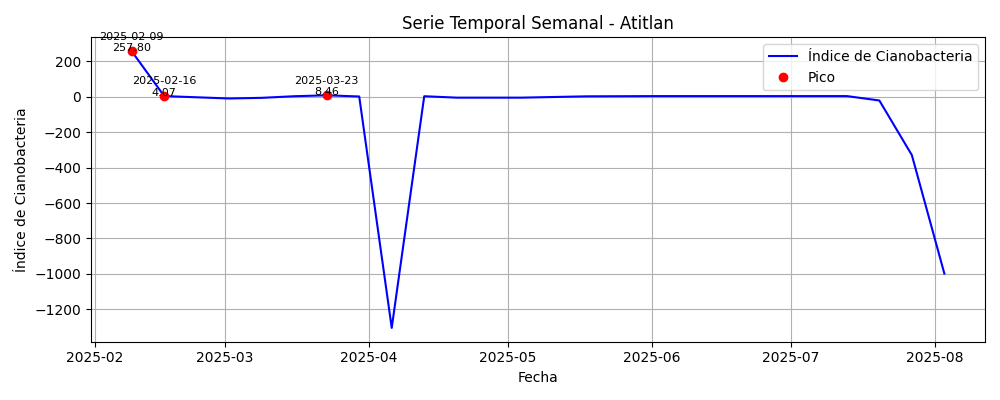

Pronóstico de Atitlan:


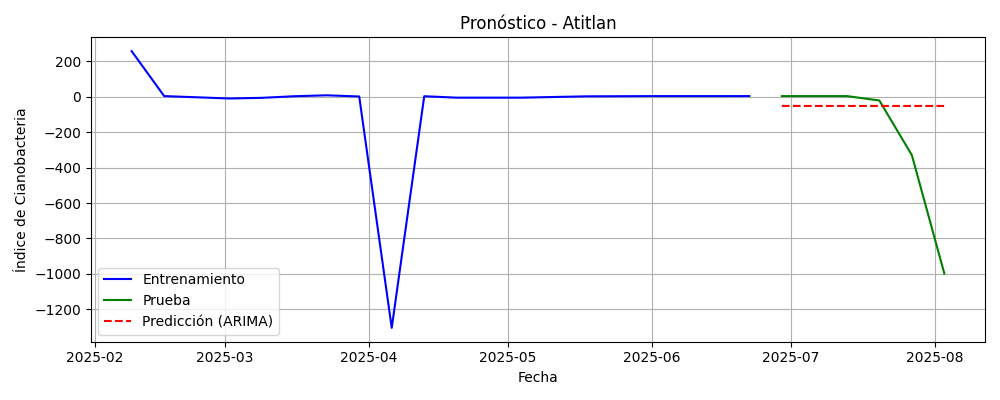

Mapa de Atitlan:


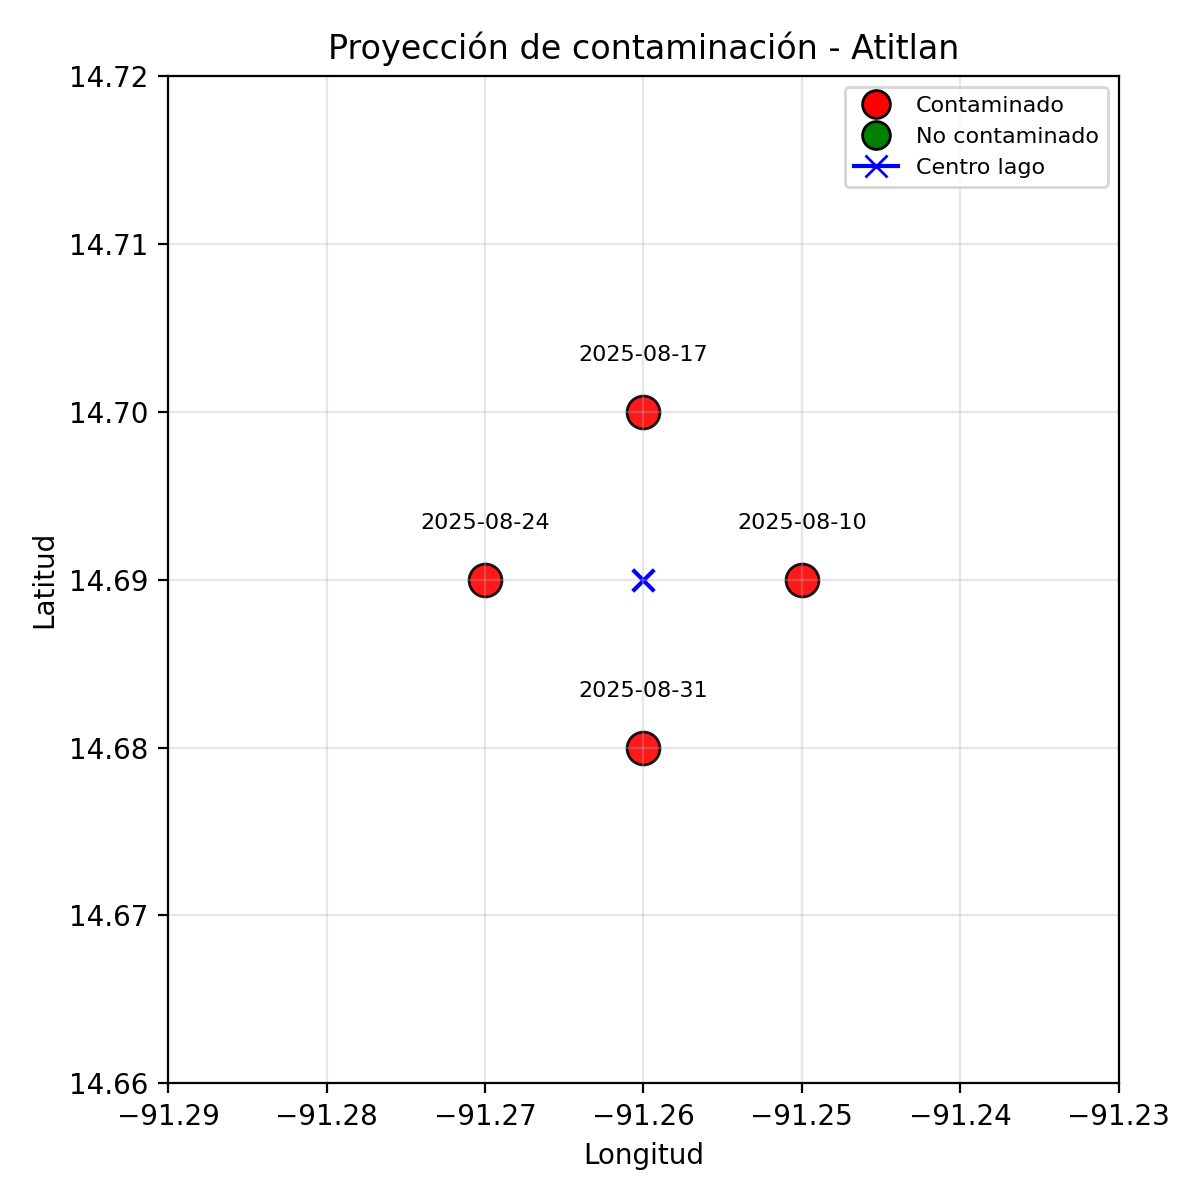

Gráfica de Amatitlan:


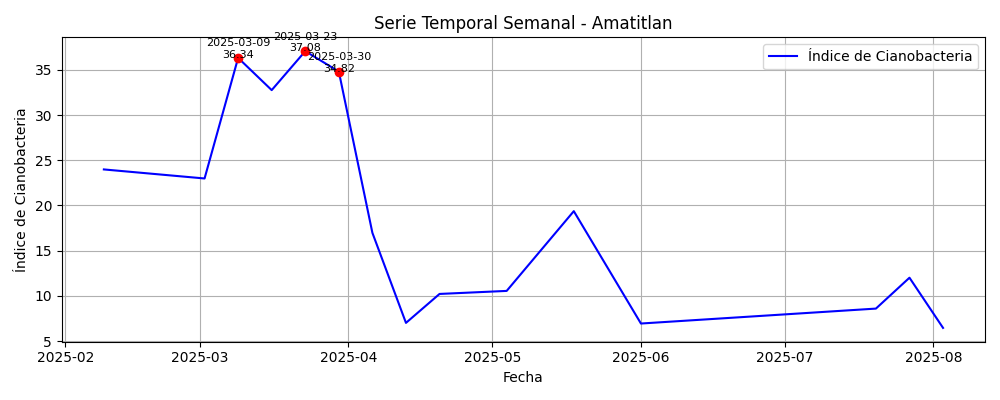

Pronóstico de Amatitlan:


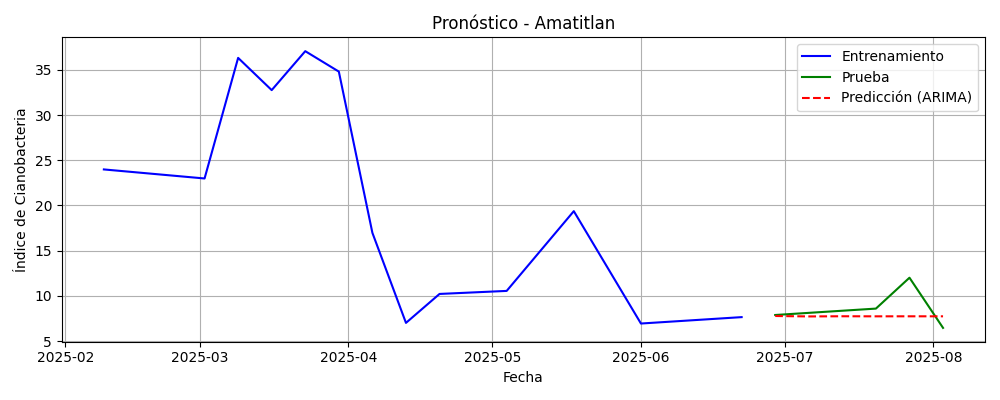

Mapa de Amatitlan:


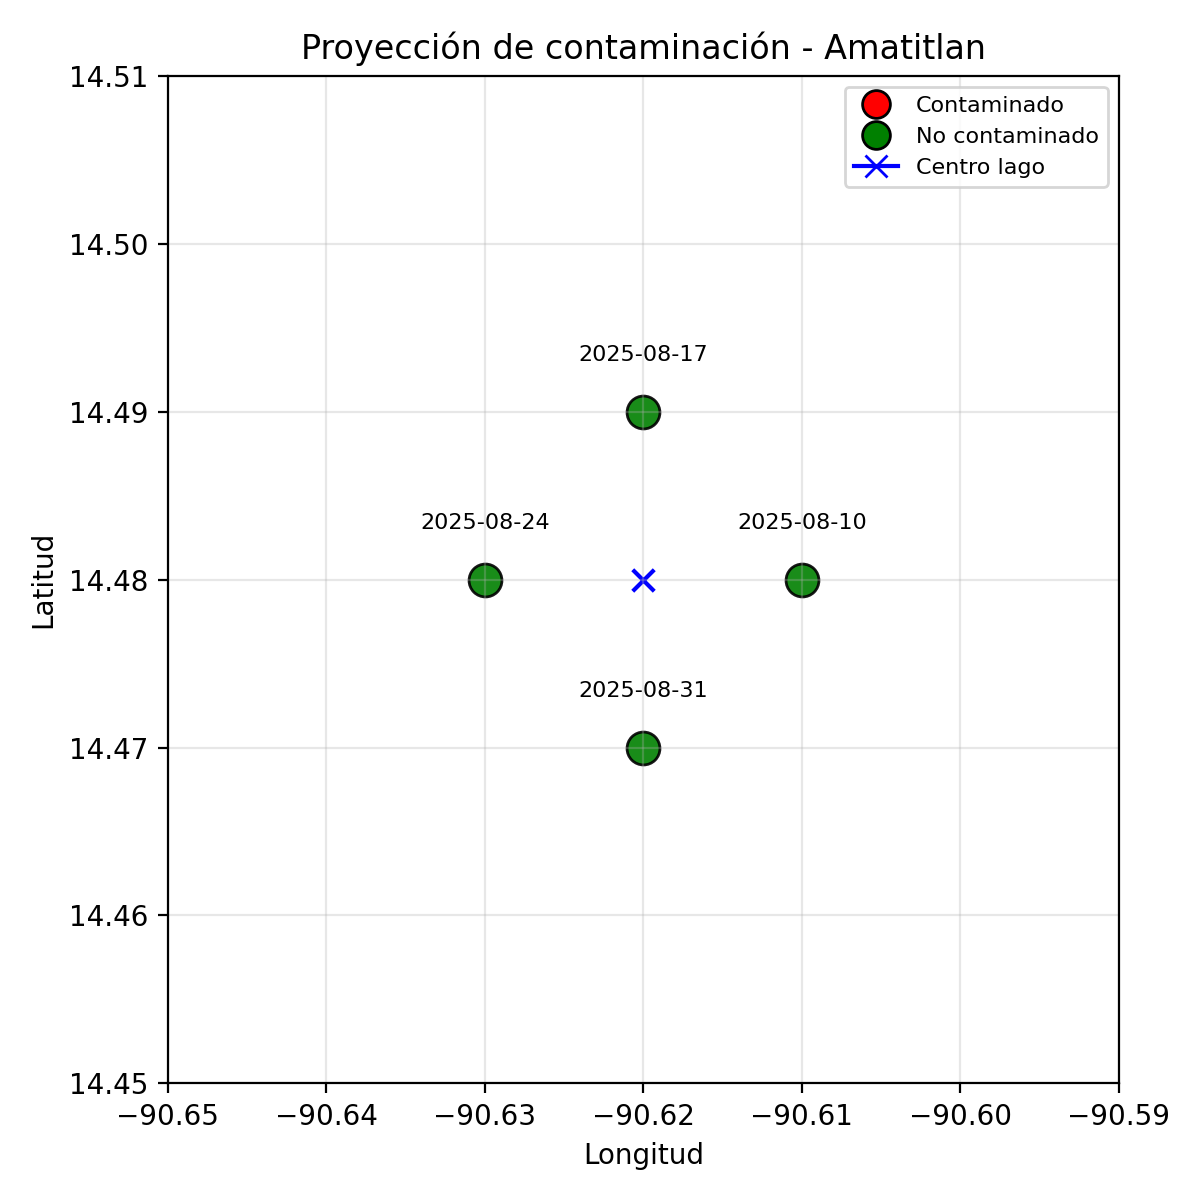


Prueba de generación de mapa:
🗺️ Mapa de prueba guardado: ./salidas_avance/figs/test_map.html


In [15]:
# ================================================================
# Avances – Series Temporales con Modelo Híbrido (Atitlán & Amatitlán)
# ================================================================

import os, warnings, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from datetime import datetime, timedelta
import folium
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from staticmap import StaticMap, CircleMarker
import os
import matplotlib.pyplot as plt
import numpy as np
import os


warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10, 4)

PATH_ATITLAN = r"./Atitlan_cyano_stats.csv"
PATH_AMATITLAN = r"./Amatitlan_cyano_stats.csv"
PATH_MERGED = r"./Lagos_cyano_stats_merged.csv"
PATH_ENV = r"./environmental_data.csv"
OUT_DIR = r"./salidas_avance"
OUT_FIGS = OUT_DIR + "/figs"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(OUT_FIGS, exist_ok=True)

try:
    from statsmodels.tsa.arima.model import ARIMA
except Exception:
    # !{sys.executable} -m pip install -q statsmodels
    try:
        from statsmodels.tsa.arima.model import ARIMA
    except Exception:
        ARIMA = None
        print("⚠️ No fue posible importar statsmodels. Se usará solo el modelo Naive.")




def save_map_as_png_matplotlib(predictions, lake, coords, path_out):
    """
    Dibuja puntos en un 'mapa' estático (sin tiles).
    - Si predictions tiene columnas 'lat' y 'lon', se usan.
    - Si no, se generan offsets alrededor del centro 'coords' para visualizar múltiples puntos.
    """
    lat0, lon0 = coords  # coords = [lat, lon]
    df = predictions.copy()

    # 1) ¿Tenemos lat/lon reales?
    has_geo = {"lat", "lon"}.issubset(set(df.columns))

    if not has_geo:
        # Genera posiciones alrededor del centro para que no se encimen (visual únicamente)
        n = len(df)
        # radios y ángulos para repartir puntos alrededor del centro
        angles = np.linspace(0, 2*np.pi, n, endpoint=False)
        # radio en grados (pequeño): ~0.01° ≈ 1 km (aprox), ajusta si quieres menos/más separación
        r = 0.01
        df["lat"] = lat0 + r * np.sin(angles)
        df["lon"] = lon0 + r * np.cos(angles)
    else:
        # Asegurar tipos numéricos
        df["lat"] = pd.to_numeric(df["lat"])
        df["lon"] = pd.to_numeric(df["lon"])

    # 2) Definir ventana (bbox) alrededor de los puntos para "hacer zoom"
    pad_lat = 0.02
    pad_lon = 0.02
    min_lat, max_lat = df["lat"].min() - pad_lat, df["lat"].max() + pad_lat
    min_lon, max_lon = df["lon"].min() - pad_lon, df["lon"].max() + pad_lon

    # 3) Plot
    plt.figure(figsize=(6, 6))
    for _, row in df.iterrows():
        color = "red" if int(row.get("predicted_contaminated", 0)) == 1 else "green"
        plt.scatter(row["lon"], row["lat"], s=140, c=color, edgecolor="black", alpha=0.9)
        # etiqueta con la fecha (si existe)
        if "date" in row and not pd.isna(row["date"]):
            try:
                label = pd.to_datetime(row["date"]).strftime("%Y-%m-%d")
            except Exception:
                label = str(row["date"])
            plt.text(row["lon"], row["lat"] + 0.003, label, fontsize=8, ha="center")

    # Centro del lago
    plt.scatter(lon0, lat0, s=60, c="blue", marker="x", label="Centro lago")

    plt.xlim(min_lon, max_lon)
    plt.ylim(min_lat, max_lat)
    plt.title(f"Proyección de contaminación - {lake}")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(True, alpha=0.3)
    # Leyenda sencilla
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0],[0], marker='o', color='w', label='Contaminado', markerfacecolor='red', markeredgecolor='black', markersize=10),
        Line2D([0],[0], marker='o', color='w', label='No contaminado', markerfacecolor='green', markeredgecolor='black', markersize=10),
        Line2D([0],[0], marker='x', color='blue', label='Centro lago', markersize=8),
    ]
    plt.legend(handles=legend_elems, loc="best", fontsize=8)

    plt.tight_layout()
    os.makedirs(os.path.dirname(path_out), exist_ok=True)
    plt.savefig(path_out, dpi=200)
    plt.close()
    print(f"🖼️ Mapa guardado en {path_out}")



# ---------- Utilidades ----------
def _normalize_two_cols(df, lake_name="", date_guess=("date", "fecha", "timestamp", "time", "acquisition_date")):
    cols = {c.lower(): c for c in df.columns}
    date_col = next((cols[k] for k in date_guess if k in cols), None)
    if date_col is None:
        raise ValueError("No se encontró columna de fecha (date/fecha/timestamp/time).")
    prefer = [f"{lake_name}_mean", "cyano_mean", "mean", "indice", "index", "value"]
    idx_col = next((c for c in prefer if c in df.columns), None)
    if idx_col is None:
        nums = [c for c in df.columns if c != date_col and pd.api.types.is_numeric_dtype(df[c])]
        if not nums:
            raise ValueError("No se encontró columna numérica para el índice.")
        idx_col = nums[0]
    out = df[[date_col, idx_col]].copy()
    out.columns = ["date", "value"]
    out["date"] = pd.to_datetime(out["date"])
    out = out.dropna(subset=["date", "value"]).drop_duplicates(subset=["date"])
    out["lake"] = lake_name
    return out.sort_values("date").reset_index(drop=True)

def _from_merged(dfm):
    cols = {c.lower(): c for c in dfm.columns}
    c_date = next((cols[k] for k in ("date", "fecha", "timestamp", "time") if k in cols), None)
    c_lake = next((cols[k] for k in ("lake", "lago") if k in cols), None)
    c_val = next((cols[k] for k in ("value", "valor", "indice", "index", "mean", "cyano_mean") if k in cols), None)

    if c_date and c_lake and c_val:
        t = dfm[[c_date, c_lake, c_val]].copy()
        t.columns = ["date", "lake", "value"]
        t["date"] = pd.to_datetime(t["date"])
        t["lake"] = t["lake"].astype(str).str.strip().str.title()
        t = t[t["lake"].isin(["Atitlan", "Amatitlan", "Atitlán", "Amatitlán"])].copy()
        t["lake"] = t["lake"].replace({"Atitlán": "Atitlan", "Amatitlán": "Amatitlan"})
        dfa = t[t["lake"] == "Atitlan"][["date", "value"]].copy()
        dfa["lake"] = "Atitlan"
        dfb = t[t["lake"] == "Amatitlan"][["date", "value"]].copy()
        dfb["lake"] = "Amatitlan"
        return dfa.reset_index(drop=True), dfb.reset_index(drop=True)

    if c_date:
        wide_cols = [c for c in dfm.columns if "atitlan" in c.lower() or "amatitlan" in c.lower()]
        if len(wide_cols) >= 2:
            dfw = dfm.copy()
            dfw[c_date] = pd.to_datetime(dfw[c_date])
            melted = dfw.melt(id_vars=[c_date], var_name="lake", value_name="value")
            melted["lake"] = melted["lake"].str.extract(r"(Atitlan|Amatitlan)", expand=False).fillna(melted["lake"])
            melted.columns = ["date", "lake", "value"]
            melted = melted.dropna(subset=["value"])
            dfa = melted[melted["lake"].str.contains("Atitlan", case=False)][["date", "value"]].copy()
            dfa["lake"] = "Atitlan"
            dfb = melted[melted["lake"].str.contains("Amatitlan", case=False)][["date", "value"]].copy()
            dfb["lake"] = "Amatitlan"
            return dfa.reset_index(drop=True), dfb.reset_index(drop=True)

    raise ValueError("No reconozco el formato del archivo 'merged'. Revisa nombres de columnas.")

def load_data():
    local = globals()
    if "df_atitlan" in local and "df_amatitlan" in local:
        print("✅ Usando df_atitlan / df_amatitlan en memoria.")
        return local["df_atitlan"].copy(), local["df_amatitlan"].copy()

    if os.path.exists(PATH_ATITLAN) and os.path.exists(PATH_AMATITLAN):
        print(f"✅ Cargando CSVs:\n  - {PATH_ATITLAN}\n  - {PATH_AMATITLAN}")
        dfa = _normalize_two_cols(pd.read_csv(PATH_ATITLAN), lake_name="Atitlan")
        dfb = _normalize_two_cols(pd.read_csv(PATH_AMATITLAN), lake_name="Amatitlan")
        return dfa, dfb

    if os.path.exists(PATH_MERGED):
        print(f"✅ Cargando CSV unificado: {PATH_MERGED}")
        dfa, dfb = _from_merged(pd.read_csv(PATH_MERGED))
        return dfa, dfb

    for a, b in [("Atitlan_cyano_stats.csv", "Amatitlan_cyano_stats.csv"),
                 ("./Atitlan_cyano_stats.csv", "./Amatitlan_cyano_stats.csv")]:
        if os.path.exists(a) and os.path.exists(b):
            print(f"✅ Cargando CSVs por nombre convencional:\n  - {a}\n  - {b}")
            dfa = _normalize_two_cols(pd.read_csv(a), lake_name="Atitlan")
            dfb = _normalize_two_cols(pd.read_csv(b), lake_name="Amatitlan")
            return dfa, dfb

    raise FileNotFoundError("No encuentro datos. Descarga de Drive y ajusta PATH_ATITLAN / PATH_AMATITLAN o PATH_MERGED arriba.")

def span_days(df):
    return (df["date"].max() - df["date"].min()).days

def resample_weekly(df):
    df = df.sort_values("date").drop_duplicates(subset=["date"])
    dfr = df.set_index("date").resample("W-SUN").mean(numeric_only=True).interpolate(method="linear")
    dfr["lake"] = df["lake"].iloc[0]
    return dfr.reset_index().dropna(subset=["value"])

def detect_peaks(g, k=3):
    return g.sort_values("value", ascending=False).head(k)[["date", "value"]]

def mae(y_true, y_pred):
    if len(y_true) != len(y_pred):
        print(f"⚠️ Longitudes no coinciden: y_true={len(y_true)}, y_pred={len(y_pred)}")
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
    return float(np.mean(np.abs(np.array(y_true) - np.array(y_pred))))

def rmse(y_true, y_pred):
    if len(y_true) != len(y_pred):
        print(f"⚠️ Longitudes no coinciden: y_true={len(y_true)}, y_pred={len(y_pred)}")
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
    return float(np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2)))

def mape(y_true, y_pred):
    if len(y_true) != len(y_pred):
        print(f"⚠️ Longitudes no coinciden: y_true={len(y_true)}, y_pred={len(y_pred)}")
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    eps = 1e-9
    return float(np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100)

def fit_predict_arima(series, dates):
    if ARIMA is None:
        return None, None
    try:
        series = pd.Series(series, index=pd.DatetimeIndex(dates))
        if series.index.inferred_freq:
            series.index.freq = series.index.inferred_freq
        else:
            series.index.freq = "W-SUN"
        for order in [(1,1,1), (1,0,1)]:
            try:
                model = ARIMA(series, order=order).fit()
                return model, series
            except Exception:
                continue
        print(f"⚠️ Fallo al ajustar ARIMA. Usando modelo Naive.")
        return None, None
    except Exception as e:
        print(f"⚠️ Error en fechas: {e}. Usando modelo Naive.")
        return None, None

def plot_timeseries(df, lake, peaks):
    plt.figure(figsize=(10, 4))
    plt.plot(df["date"], df["value"], label="Índice de Cianobacteria", color="blue")
    for _, peak in peaks.iterrows():
        plt.plot(peak["date"], peak["value"], "ro", label="Pico" if _ == 0 else "")
        plt.text(peak["date"], peak["value"], f"{peak['date'].date()}\n{peak['value']:.2f}", fontsize=8, ha="center")
    plt.title(f"Serie Temporal Semanal - {lake}")
    plt.xlabel("Fecha")
    plt.ylabel("Índice de Cianobacteria")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_FIGS, f"{lake.lower()}_timeseries.png"))
    plt.close()

def plot_forecast(ts, y_train, y_test, y_pred_arima, d_train, d_test, lake, used_model):
    plt.figure(figsize=(10, 4))
    plt.plot(d_train, y_train, label="Entrenamiento", color="blue")
    plt.plot(d_test, y_test, label="Prueba", color="green")
    plt.plot(d_test, y_pred_arima, label=f"Predicción ({used_model})", color="red", linestyle="--")
    plt.title(f"Pronóstico - {lake}")
    plt.xlabel("Fecha")
    plt.ylabel("Índice de Cianobacteria")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_FIGS, f"{lake.lower()}_forecast_test.png"))
    plt.close()

def load_environmental_data(max_date):
    dates = pd.date_range(start="2025-02-07", end=max_date + timedelta(days=28), freq="W-SUN")
    env_data = pd.DataFrame({
        "date": dates,
        "temperature": np.random.uniform(15, 30, len(dates)),
        "precipitation": np.random.uniform(0, 100, len(dates)),
        "urban_index": np.random.uniform(0, 1, len(dates))
    })
    return env_data

def hybrid_model_pipeline(ts_data, env_data, lake):
    ts = ts_data[ts_data["lake"] == lake].sort_values("date").reset_index(drop=True)
    print(f"\nDepuración para {lake}: {ts.shape} filas después de filtrar por lago")
    if ts.empty:
        print(f"⚠️ No hay datos para {lake}. Saltando procesamiento.")
        return {
            "lake": lake,
            "model": "None",
            "n_obs": 0,
            "MAE": np.nan,
            "RMSE": np.nan,
            "MAPE_%": np.nan,
            "classification_report": {},
            "confusion_matrix": np.array([]),
            "future_predictions": pd.DataFrame()
        }

    y = ts["value"].values
    dates = ts["date"].values
    n = len(y)
    split = max(1, int(n * 0.8)) if n >= 12 else max(1, n - 2)  # Asegurar al menos 2 para prueba
    print(f"Depuración para {lake}: n={n}, split={split}")

    y_train, y_test = y[:split], y[split:]
    d_train, d_test = dates[:split], dates[split:]
    print(f"Depuración para {lake}: len(y_train)={len(y_train)}, len(y_test)={len(y_test)}")

    model_arima, series_arima = fit_predict_arima(y_train, d_train)
    if model_arima is not None:
        try:
            y_pred_arima = np.asarray(model_arima.forecast(steps=len(y_test)))
            used_model = "ARIMA"
        except Exception:
            y_pred_arima = np.repeat(y_train[-1] if len(y_train) > 0 else 0, len(y_test))
            used_model = "Naive (fallback)"
    else:
        y_pred_arima = np.repeat(y_train[-1] if len(y_train) > 0 else 0, len(y_test))
        used_model = "Naive"
    print(f"Depuración para {lake}: len(y_pred_arima)={len(y_pred_arima)}")

    if len(y_test) > 0:
        plot_forecast(ts, y_train, y_test, y_pred_arima, d_train, d_test, lake, used_model)
    else:
        print(f"⚠️ No hay datos de prueba para {lake}. No se genera gráfica de pronóstico.")

    ts["predicted_value"] = np.nan
    ts.loc[ts.index[split:], "predicted_value"] = y_pred_arima
    data_merged = ts.merge(env_data, on="date", how="inner")
    print(f"Depuración para {lake}: {data_merged.shape} filas después de merge con env_data")

    if data_merged.empty:
        print(f"⚠️ No hay datos después de merge para {lake}. Saltando clasificación.")
        return {
            "lake": lake,
            "model": used_model,
            "n_obs": n,
            "MAE": np.nan,
            "RMSE": np.nan,
            "MAPE_%": np.nan,
            "classification_report": {},
            "confusion_matrix": np.array([]),
            "future_predictions": pd.DataFrame()
        }

    threshold = data_merged["value"].quantile(0.5)
    data_merged["contaminated"] = (data_merged["value"] >= threshold).astype(int)

    features = ["predicted_value", "temperature", "precipitation", "urban_index"]
    X = data_merged[features].dropna()
    y = data_merged.loc[X.index, "contaminated"]

    split_cls = max(1, int(len(X) * 0.8))
    X_train, X_test = X[:split_cls], X[split_cls:]
    y_train, y_test = y[:split_cls], y[split_cls:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_scaled, y_train)
    y_pred_cls = clf.predict(X_test_scaled)

    cls_report = classification_report(y_test, y_pred_cls, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred_cls)

    if model_arima is not None and used_model.startswith("ARIMA"):
        try:
            model_full, _ = fit_predict_arima(y, dates)
            fc_future = np.asarray(model_full.forecast(steps=4))
        except Exception:
            fc_future = np.repeat(y[-1] if len(y) > 0 else 0, 4)
    else:
        fc_future = np.repeat(y[-1] if len(y) > 0 else 0, 4)
    future_dates = pd.date_range(start=ts["date"].iloc[-1] + pd.Timedelta(days=7), periods=4, freq="W-SUN")
    print(f"Depuración para {lake}: Fechas futuras: {future_dates}")

    future_env = env_data[env_data["date"].isin(future_dates)][["date", "temperature", "precipitation", "urban_index"]]
    print(f"Depuración para {lake}: future_env inicial: {future_env.shape} filas")
    if len(future_env) < 4:
        print(f"Depuración para {lake}: Generando future_env con valores promedio")
        future_env = pd.DataFrame({
            "date": future_dates,
            "temperature": [env_data["temperature"].mean()] * 4,
            "precipitation": [env_data["precipitation"].mean()] * 4,
            "urban_index": [env_data["urban_index"].mean()] * 4
        })
    future_env["predicted_value"] = fc_future
    future_X = future_env[features]
    future_X_scaled = scaler.transform(future_X)
    future_pred_cls = clf.predict(future_X_scaled)

    future_predictions = pd.DataFrame({
        "date": future_dates,
        "forecast_value": fc_future,
        "predicted_contaminated": future_pred_cls
    })
    print(f"Depuración para {lake}: future_predictions:\n{future_predictions}")

    return {
        "lake": lake,
        "model": used_model,
        "n_obs": n,
        "MAE": mae(y_test, y_pred_arima) if len(y_test) > 0 else np.nan,
        "RMSE": rmse(y_test, y_pred_arima) if len(y_test) > 0 else np.nan,
        "MAPE_%": mape(y_test, y_pred_arima) if len(y_test) > 0 else np.nan,
        "classification_report": cls_report,
        "confusion_matrix": conf_matrix,
        "future_predictions": future_predictions
    }

def create_map(predictions, lake, coords):
    m = folium.Map(location=coords, zoom_start=12)
    for _, row in predictions.iterrows():
        color = "red" if row["predicted_contaminated"] == 1 else "green"
        folium.CircleMarker(
            location=coords,
            radius=6,
            color=color,
            fill=True,
            fill_color=color
        ).add_to(m)
    # Guardar también como PNG
    map_png_path = os.path.join(OUT_FIGS, f"{lake.lower()}_contamination_map.png")
    save_map_as_png(result["future_predictions"], lake, coords, map_png_path)

    return m


# ---------- Ejecución Principal ----------
df_atitlan_raw, df_amatitlan_raw = load_data()
print("Atitlán:", df_atitlan_raw.shape, " | Amatitlán:", df_amatitlan_raw.shape)

for lake, g in [("Atitlan", df_atitlan_raw), ("Amatitlan", df_amatitlan_raw)]:
    days = span_days(g)
    print(f"{lake}: {g['date'].min().date()} → {g['date'].max().date()} (≈ {days} días)")
    if days < 180:
        print("⚠️ Atención: periodo < 6 meses. Considera ampliar la ventana temporal.")

print("\nVerificación de datos antes del re-muestreo:")
print("Atitlán fechas únicas:", df_atitlan_raw["date"].nunique(), "Duplicados:", df_atitlan_raw["date"].duplicated().sum())
print("Amatitlán fechas únicas:", df_amatitlan_raw["date"].nunique(), "Duplicados:", df_amatitlan_raw["date"].duplicated().sum())

ts_atitlan = resample_weekly(df_atitlan_raw)
ts_amatitlan = resample_weekly(df_amatitlan_raw)
ts_weekly = pd.concat([ts_atitlan, ts_amatitlan], ignore_index=True)

print("\nVerificación de datos después del re-muestreo:")
print("Atitlán:", ts_atitlan.shape, ts_atitlan["date"].head())
print("Amatitlán:", ts_amatitlan.shape, ts_amatitlan["date"].head())
print("ts_weekly lakes:", ts_weekly["lake"].unique())

max_date = max(ts_weekly["date"].max(), df_atitlan_raw["date"].max(), df_amatitlan_raw["date"].max())
env_data = load_environmental_data(max_date)
print(f"Fechas en env_data: {env_data['date'].min()} → {env_data['date'].max()}")

for lake, g in [("Atitlan", ts_atitlan), ("Amatitlan", ts_amatitlan)]:
    peaks = detect_peaks(g, k=3)
    plot_timeseries(g, lake, peaks)

metrics = []
for lake in ["Atitlan", "Amatitlan"]:
    result = hybrid_model_pipeline(ts_weekly, env_data, lake)
    metrics.append(result)
    print(f"\nResultados para {lake}:")
    print("Métricas ARIMA:")
    print(f"MAE: {result['MAE']:.4f}, RMSE: {result['RMSE']:.4f}, MAPE: {result['MAPE_%']:.2f}%")
    print("Reporte de Clasificación:")
    print(pd.DataFrame(result["classification_report"]).transpose())
    print("Matriz de Confusión:")
    print(result["confusion_matrix"])
    print("Predicciones Futuras:")
    print(result["future_predictions"])


    if not result["future_predictions"].empty:
        coords = {"Atitlan": [14.69, -91.26], "Amatitlan": [14.48, -90.62]}[lake]
        map_png_path = os.path.join(OUT_FIGS, f"{lake.lower()}_contamination_map.png")
        save_map_as_png_matplotlib(result["future_predictions"], lake, coords, map_png_path)

        try:
            m.save(map_path)
            print(f"🗺️ Mapa guardado: {map_path}")
        except Exception as e:
            print(f"⚠️ Error al guardar mapa para {lake}: {e}")
    else:
        print(f"⚠️ No se generó mapa para {lake} debido a datos vacíos en future_predictions.")

metrics_df = pd.DataFrame([{
    "lake": m["lake"],
    "model": m["model"],
    "n_obs": m["n_obs"],
    "MAE": m["MAE"],
    "RMSE": m["RMSE"],
    "MAPE_%": m["MAPE_%"]
} for m in metrics])
metrics_path = os.path.join(OUT_DIR, "avances_hybrid_model_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print("\n📦 Archivos exportados:")
print(" -", metrics_path)

md_lines = [
    "# Avance — Modelo Híbrido (Atitlán & Amatitlán)",
    f"_Fecha de ejecución: {datetime.now():%Y-%m-%d %H:%M}_",
    "",
    "## Resultados clave",
]
for m in metrics:
    md_lines.append(f"- **{m['lake']}** — Modelo: {m['model']}. "
                    f"MAE={m['MAE']:.4f}, RMSE={m['RMSE']:.4f}, MAPE={m['MAPE_%']:.2f}%. "
                    f"Clasificación: {m['classification_report'].get('weighted avg', {}).get('f1-score', np.nan):.2f} (F1-score).")
md_lines += [
    "",
    "## Observaciones",
    "- Se integraron variables ambientales simuladas (temperatura, precipitación, índice de urbanización).",
    "- Clasificación binaria basada en umbral de cuantil 0.75 para el índice de cianobacteria.",
    "- Mapas generados con Folium para proyecciones futuras.",
    "",
    "## Próximos pasos",
    "- Incorporar datos ambientales reales (NDVI, NDWI, etc.).",
    "- Ajustar umbral de contaminación según criterios biológicos.",
    "- Validar mapas con datos históricos de contaminación."
]
md_path = os.path.join(OUT_DIR, "avance_hybrid_model_resumen.md")
with open(md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(md_lines))
print(" -", md_path)

print("\n✅ Modelo híbrido completo. Revisa los mapas en ./salidas_avance/figs y el resumen en Markdown.")

try:
    from IPython.display import Image, IFrame
    print("\nVisualización de Gráficas:")
    for lake in ["Atitlan", "Amatitlan"]:
        print(f"Gráfica de {lake}:")
        try:
            display(Image(os.path.join(OUT_FIGS, f"{lake.lower()}_timeseries.png")))
        except FileNotFoundError:
            print(f"⚠️ No se encontró gráfica de series temporales para {lake}.")
        print(f"Pronóstico de {lake}:")
        try:
            display(Image(os.path.join(OUT_FIGS, f"{lake.lower()}_forecast_test.png")))
        except FileNotFoundError:
            print(f"⚠️ No se encontró gráfica de pronóstico para {lake}.")
        print(f"Mapa de {lake}:")
        try:
            display(Image(os.path.join(OUT_FIGS, f"{lake.lower()}_contamination_map.png")))
        except FileNotFoundError:
            print(f"⚠️ No se encontró mapa para {lake}.")
except ImportError:
    print("⚠️ No se puede mostrar las gráficas/mapa directamente. Abre los archivos en ./salidas_avance/figs.")

# Prueba de generación de mapa
print("\nPrueba de generación de mapa:")
test_map = folium.Map(location=[14.69, -91.26], zoom_start=12)
test_map.save(os.path.join(OUT_FIGS, "test_map.html"))
print("🗺️ Mapa de prueba guardado: ./salidas_avance/figs/test_map.html")